## ***This notebook showcases how DPMN-hERG(Cai et al datasets) , and Eos30f3 model generalise to new and unseen data. Done by Malik Badmus as part of Outreachy 2024 contributions***

In [124]:
import os
import sys
import pandas as pd
from rdkit import Chem
from rdkit.Chem import inchi
import matplotlib.pyplot as plt

# search path for modules 
sys.path.append(os.path.abspath("../src"))
DATAPATH = "../data"
SRC= "../src"

#File path
output_path_file = os.path.join(DATAPATH, "Raw", "external.csv")
input_file_path = os.path.join(DATAPATH, "Raw", "Cai_TableS3_fixed.csv")
input_file_path_1 = os.path.join(DATAPATH, "Raw", "I_test.csv")


***The external datasets i am using for this validation was sourced from the theurapatic data commons, the TDC contains 11 (Eleven) toxicity related datasets, of these numbers, 3 (Three) of them are related to Human ether-à-go-go related gene (hERG), I choose the hERG blockers datasets, To gauge both model performance to unseen data.***

In [125]:
#IMPORTING DATASETS FROM TDC

from tdc.single_pred import Tox
data = Tox(name = 'hERG').get_data()
df = pd.DataFrame(data)
df.to_csv(output_path_file, index=False)

Found local copy...
Loading...


Done!


***Inspect the datasets***

In [126]:
df.head()

,Drug_ID,Drug,Y
0,DEMETHYLASTEMIZOLE,Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,1.0
1,GBR-12909,Fc1ccc(C(OCC[NH+]2CC[NH+](CCCc3ccccc3)CC2)c2cc...,1.0
2,LY-97241,CCCCCCCN(CC)CCCCc1ccc([N+](=O)[O-])cc1,1.0
3,CLOFILIUM PHOSPHATE,CCCCCCC[N+](CC)(CC)CCCCc1ccc(Cl)cc1.CCCCCCC[N+...,1.0
4,FLUSPIRILENE,O=C1NCN(c2ccccc2)C12CC[NH+](CCCC(c1ccc(F)cc1)c...,1.0


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Drug_ID  633 non-null    object 
 1   Drug     655 non-null    object 
 2   Y        655 non-null    float64
dtypes: float64(1), object(2)
memory usage: 15.5+ KB


***Our external datasets contains 655 drugs with their corresponding biaoactive label.***

### Removing molecules that were present in cai et al datasets used to train the DPMN-hERG model from our External Test set.

***It is important to note that different valid SMILES strings can represent the same molecular structure, Comparing this molecules based solely on SMILES strings might then lead to discrepancies, so it is crucial to generate the inchi keys of the Smiles column and based our comparison on that.***

In [128]:

from processing import generate_inchi_key

cai_dataset = pd.read_csv(input_file_path, delimiter=',')

cai_dataset['inchi key'] = cai_dataset['smiles'].apply(generate_inchi_key)

df['Drug_ID'] = df['Drug'].apply(generate_inchi_key)

df.rename(columns={'Drug_ID': 'inchi key', 'Drug': 'smiles'}, inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inchi key  655 non-null    object 
 1   smiles     655 non-null    object 
 2   Y          655 non-null    float64
dtypes: float64(1), object(2)
memory usage: 15.5+ KB


In [129]:
cai_dataset.info()

cai_dataset.to_csv('../data/cai_inchi.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7889 entries, 0 to 7888
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   smiles     7889 non-null   object 
 1   X10        7889 non-null   int64  
 2   X20        6548 non-null   float64
 3   X40        5434 non-null   float64
 4   X60        5161 non-null   float64
 5   X80        4940 non-null   float64
 6   X100       4831 non-null   float64
 7   inchi key  7889 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 493.2+ KB


In [130]:

common_values = df['inchi key'].isin(cai_dataset['inchi key'])
same_val = df[common_values].index
matching_rows = df.loc[same_val]

matching_rows.head(10)


,inchi key,smiles,Y
0,LAGYWHSFHIMTPE-UHFFFAOYSA-N,Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,1.0
2,YTYATOMQOOFRNA-UHFFFAOYSA-N,CCCCCCCN(CC)CCCCc1ccc([N+](=O)[O-])cc1,1.0
3,SLOWBFFBASJEAL-UHFFFAOYSA-K,CCCCCCC[N+](CC)(CC)CCCCc1ccc(Cl)cc1.CCCCCCC[N+...,1.0
4,QOYHHIBFXOOADH-UHFFFAOYSA-O,O=C1NCN(c2ccccc2)C12CC[NH+](CCCC(c1ccc(F)cc1)c...,1.0
5,FEBOTPHFXYHVPL-UHFFFAOYSA-N,O=C(CCCN1CCC(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F)cc1,1.0
6,UDRWVFGKMDCPTL-UHFFFAOYSA-N,Fc1ccc(-n2cc(C3CCN(CCN4CCNC4=S)CC3)c3ccccc32)cc1,1.0
7,QPOLRENOYJQNEP-UHFFFAOYSA-N,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccccc23)CC1,1.0
8,NAUWTFJOPJWYOT-UHFFFAOYSA-N,Fc1ccc(C(OCCN2CCN(CCCc3ccccc3)CC2)c2ccc(F)cc2)cc1,1.0
9,UISIMLLBTGLBND-UHFFFAOYSA-N,CS(=O)(=O)Nc1ccc2c(c1)C(=O)CC1(CCN(CCc3ccc4non...,1.0
10,GUGOEEXESWIERI-PMERELPUSA-O,CC(C)(C)c1ccc([C@@H](O)CCC[NH+]2CCC(C(O)(c3ccc...,1.0


In [131]:
matching_rows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515 entries, 0 to 639
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inchi key  515 non-null    object 
 1   smiles     515 non-null    object 
 2   Y          515 non-null    float64
dtypes: float64(1), object(2)
memory usage: 16.1+ KB


***515 Molecules used in Training DPMN-hERG model is present in our external test set, i will go ahead to remove this molecule so that we will be left with new data that the model was not exposed to during training.***

In [132]:
df.drop(same_val, inplace=True)

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, 1 to 654
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inchi key  140 non-null    object 
 1   smiles     140 non-null    object 
 2   Y          140 non-null    float64
dtypes: float64(1), object(2)
memory usage: 4.4+ KB


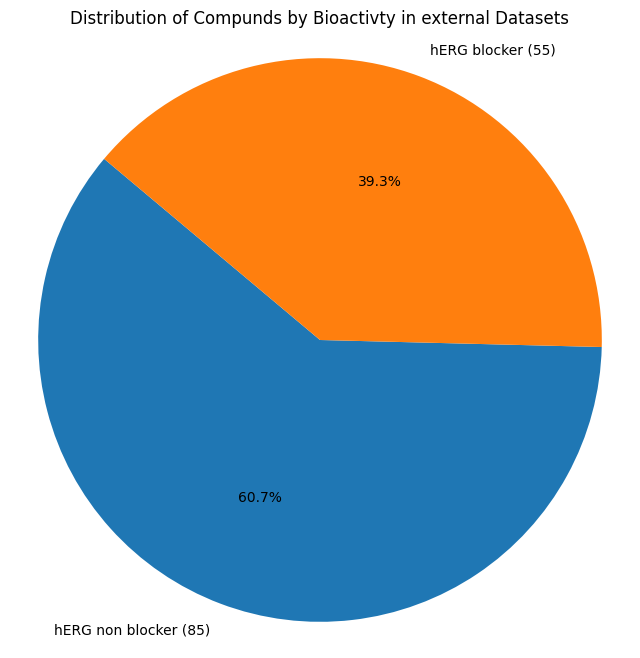

In [134]:
class_counts = df['Y'].value_counts()
class_names = {0: 'hERG non blocker', 1: 'hERG blocker'}

# Create a pie chart
plt.figure(figsize=(8, 8))  
wedges, texts, autotexts = plt.pie(class_counts, labels=class_counts.index.map(class_names), autopct='%1.1f%%', startangle=140)
for i, label in enumerate(texts):
    label.set_text(f"{label.get_text()} ({class_counts[i]})")

plt.title('Distribution of Compunds by Bioactivty in external Datasets')  
plt.axis('equal')  
plt.show()

***We can observe the number of data points in each bioactivity class of our new datasets***